In this class we will see how to deal with large state spaces. We have no access to the transition kernel nor the reward function.

- Fitted Q iterations
- Deep Q learning

In [14]:
# To run cells, push MAJ-ENTER or click on the play button at the left of the cells
# Please turn-off AI: from the Tools menu, select Settings, followed by AI assistance. In that space, you'll be able to revoke consent and hide AI coding features.

In [15]:
# Let us first install gymnasium
!pip install swig
!pip install gymnasium matplotlib scikit-learn
!pip install tqdm
!pip install torch
!pip install rlclass

In [16]:
# Many environment are available
import gymnasium
gymnasium.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

# Cart Pole

This environment is part of the Classic Control environments which contains general information about the environment.


## Description

This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

# Action Space

The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

    0: Push cart to the left

    1: Push cart to the right

Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

# Observation Space

The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:


|Num | Observation|  Min | Max
|----|-------------|------|-----
|0 | Cart Position |-4.8 |4.8
|1 |Cart Velocity |-Inf| Inf
|2 |Pole Angle |~ -0.418 rad (-24°) |~ 0.418 rad (24°)
|3 |Pole Angular Velocity| -Inf |Inf

Note: While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:

    The cart x-position (index 0) can be take values between (-4.8, 4.8), but the episode terminates if the cart leaves the (-2.4, 2.4) range.

    The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°)


# Rewards

Since the goal is to keep the pole upright for as long as possible, by default, a reward of +1 is given for every step taken, including the termination step. The default reward threshold is 500 for v1 and 200 for v0 due to the time limit on the environment.

If sutton_barto_reward=True, then a reward of 0 is awarded for every non-terminating step and -1 for the terminating step. As a result, the reward threshold is 0 for v0 and v1.

# Starting State

All observations are assigned a uniformly random value in (-0.05, 0.05)
Episode End

The episode ends if any one of the following occurs:

    Termination: Pole Angle is greater than ±12°

    Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

    Truncation: Episode length is greater than 500 (200 for v0)


In [17]:
import numpy
import matplotlib.pyplot as plt

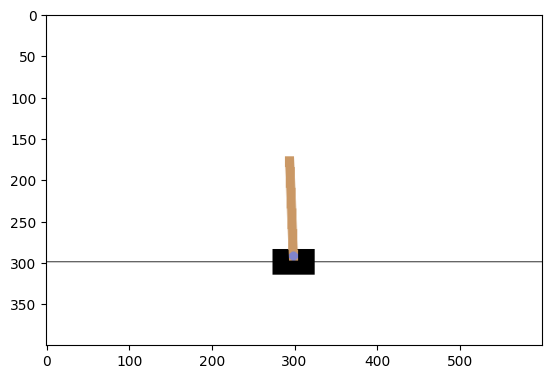

In [18]:
env = gymnasium.make('CartPole-v1', render_mode="rgb_array")
s0, _ = env.reset()
plt.imshow(env.render())

In [19]:
from rlclass.utils import make_animation

In [20]:
import  numpy as np

n_actions = env.action_space.n

def pi_uniform(s):
  return np.random.randint(0, n_actions)

def play_policy(env, pi, horizon=50, capture_rate=1):
  s, _ = env.reset()
  a = pi(s)
  imgs = []
  imgs.append(env.render())
  for tt in range(horizon):
    s, rew, term, trunc, _ = env.step(a)
    a = pi(s)
    if tt % capture_rate == 0:
      imgs.append(env.render())
    if term or trunc:
      break
  return make_animation(imgs)

def monte_carlo_eval(env, pi, horizon, gamma=0.9):
  s, _ = env.reset()
  a = pi(s)
  total_reward = 0
  for t in range(horizon):
    s, rew, term, trunc, _ = env.step(a)
    a = pi(s)
    total_reward += gamma **t * rew
    if term or trunc:
      return total_reward
  return total_reward
play_policy(env, pi_uniform, 50)

In [21]:
s, _ = env.reset()
n_actions = env.action_space.n
def pi_uniform(s):
  return np.random.randint(0, n_actions)
print(s, pi_uniform(s))

[ 0.02024125  0.03231753  0.00221414 -0.00603837] 0


# Approximate policy evaluation

Approximate policy evaluation approximates the q-value function by a parametric family $(q_{w})_{w \in \Omega}$. The policy evaluation operator is adapted so that it has values in $(q_{w})_{w \in \Omega}$. The goal is to perform policy evaluation with a complexity independent of $S$.

More precisely, the policy evaluation operator $T^{\pi}$ is replaced by $\tilde{T}^{\pi}$ defined as:
$$
\tilde{T^{\pi}}(q) = \text{argmin}_{ \{ q_w, w \in \Omega \}} d(T^{\pi}(q), q_w)
$$
where $d$ is some loss over vectors to be chosen.

Given $\tilde{T^{\pi}}$, we can perform *approximate value iteration* starting from $q^{(0)} = q_{w_0}$ by iterating:
- Choose $\pi_k$ greedy with respect to $q^{(k)}$
- Set $q^{(k+1)} = \tilde{T^{\pi_k}} q^{(k)}$

# Batched RL: the example of fitted Q iteration

Fitted Q iteration is a batch RL method where samples are collected $(s_i, a_i, s'_i)_{i=1}^n$ from running a behaviour policy $\pi'$ but $\pi'$ does not need to be accessed at training time and can even be unknown.

Then we choose $d$ to be of the form
$$
d(x, y) = \frac1{n} \sum_{i=1}^n [l(x[s_i, a_i], y_i[s_i, a_i])].
$$

We then perform approximate value iteration where $T^{\pi_k}$ is estimated via TD(0). The iterations become:
$$
q^{(k+1)} = \text{argmin}_{q_w, w \in \Omega} \frac1{n} \sum_{i=1}^n l( r_{a_i}(s_i) + \gamma \max_{a \in A} q^{(k)} (s'_i, a), q_{w}(s_i, a_i)).
$$

At each iteration, the optimization problem to solve can be seen as a supervised learning problem where the model is $q_w$ and the training data are given by $(x_i, y_i)_{i \in [n]}$ with feature $x_i = s_i, a_i$, label $y_i = r_{s_i}(a_i) + \max_{a \in A} \gamma q^{(k)}(s'_i, a)$ and loss $l$.

Below, we will focus on an approach inspired by Tree-Based Batch Mode Reinforcement Learning (Ernst, JMLR 2005, https://www.jmlr.org/papers/volume6/ernst05a/ernst05a.pdf) by solving random forrest regression at each iteration. The model $q_w$ is therefore given by a collection of decision trees and the loss $l(x, y) = \frac12 (x - y)^2$.

# Exercice 1: Implement Fitted Q iterations with random forests.

Implement fitted Q iterations with random forest using uniform exploration for $\pi'$. We assume the set of states is of dimension $d_s$ and the set of actions is of dimension $d_a$.

### Collecting the dataset
- Initialize data = $0_{n \times (2 d_s + d_a + 2)}$
- Start from $s_0$
- At iteration $t\leq n$:
  - Select action $a_t \sim \pi'( \cdot  | s_t)$ ,observe next state $s_{t+1}$ reward $r_{s_t}(a_t)$ and $1\{s_{t+1} \text{ is a terminal state }\}$.
  - Store $s_t, a_t, s_{t+1}, r_{s_t}(a_t), 1\{s_{t+1} \text{ is a terminal state }\}$ in the $t$-th line of the data matrix

### Fitted Q iterations with random forests
- Construct a dataset $X_0 = (s_t, a_t)_{t \in [n]} \in \mathbb{R}^{n \times (d_s + d_a)}$ by selecting the corresponding columns of the data matrix.
- Construct a dataset $Y_0 = (r_{a_t}(s_t))_{t \in [n]} \in \mathbb{R}^{n \times 1}$ similarly
- Fit a random forest by using the sklearn API
`model.fit(X_0, Y_0)`
- At iteration $i \leq n$:
  - Construct $X_t = X_0$
  - Construct $X'_t = (s_{t+1}, a)_{t \in [n]}$ and the estimate $(\hat{Q}(s_{t+1}, a)_{t \in [n]})$ using `model.predict(X'_t)`
  - Construct $Y_t = (r_{a_t}(s_t) + \gamma  1 \{s_{t+1} \text{ is not a terminal state }\} \max_{a \in A} \hat{Q}(s_t, a)$
  - Refit the model `model.fit(X_t, Y_t)`

Return the policy $\pi$ which is such that
$$
\pi(s) = \text{argmax}_{a \in A} \hat{Q}(s, a)
$$

In [22]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

def collect_dataset(env, pi, n):
  """
  Collect a dataset of the form $(s_i, a_i, r_{a_i}(s_i), s'_i, 1(trunc))_{i=1}^n$
  by running a policy that chooses its action uniformly at random

  Parameters
  ---------
  env: Environment
  pi: Policy
  n: int
    Number of samples to collect

  Return
  -----
  data: np array of size (n, 2d_s + d_a + 2)
    data collected by the random policy
    the first 4 columns are the states s_i,
    the 5th, 6th and 7th columns contain the actions a_i,
    rewards r_{a_i}(s_i) and whether the step is a termination step
    and the columns 8th-12th columns contain the states s'_i
  """
  d_a = env.action_space.n
  s, _ = env.reset()
  d_s = s.shape[0]
  data = []

  for iter in range(n):
    a = pi(s)
    next_state, reward, terminated, truncated, _ = env.step(a)
    data.append(s.copy().tolist() + [a, reward, terminated] + next_state.copy().tolist())
    if terminated or truncated:
      s, _ = env.reset()
    else:
      s = next_state.copy()
  return np.array(data)




def fitted_q_iterations(data, gamma, n_iterations, model):
  """
  Implements Fitted Q iteration on the collected dataset using Random Forest.

  Parameters
  ----------
  data: np array of size (n, 2d_s + d_a + 2)
    Input dataset collected using the behaviour policy (pi')
  gamma: float
    Discount parameter
  n_iterations: int
    Number of iterations to perform
  model: An initialized sklearn-like model
    It should have a fit and predict method
  Return
  ------
  pi: np array of size d_s -> int
    Function that associates to every state an action
  """
  n = len(data)
  d_a = env.action_space.n
  s, _ = env.reset()
  d_s = s.shape[0]
  X = data[:, :d_s + 1]
  Y = data[:, d_s + 1]
  term = data[:, d_s + 2]
  model.fit(X, Y)

  for iter in range(n_iterations):
    X_prime = [np.column_stack([data[:, d_s+3:], np.ones(n).reshape(-1,1) * a]) for a in range(d_a)]
    predictions = [model.predict(x) for x in X_prime]
    Qmax = np.max(predictions)
    Y = data[:, d_s + 1] + gamma * (1 - term) * Qmax
    model.fit(X, Y)

  def pi(s):
    q = [model.predict(np.array(s.tolist() + [a]).reshape(1, -1))[0] for a in range(n_actions)]
    return np.argmax(q)
  return pi


In [23]:
n = 10000
env = gymnasium.make('CartPole-v1', render_mode="rgb_array")
data = collect_dataset(env, pi_uniform, n)
print(data.shape)
pi = fitted_q_iterations(data, 0.9, n_iterations=10, model = RandomForestRegressor())
play_policy(env, pi, 100)

(10000, 11)


# Fitted Q iterations with a neural network





(Very fast) Neural networks tutorial
--------------------------------------

Ths is taken from https://pytorch.org/tutorials/beginner/basics/intro.html.
I strongly recommand to read this reference in depth if the introduction below is not enough.


**Automatic differentiation**

When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called `torch.autograd`. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input x, parameters w and b, and some loss function. It can be defined in PyTorch in the following manner:

```python
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
```

In this network, w and b are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the requires_grad property of those tensors.

To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely, we need $\nabla_w l_{w, b}(x, y)​$ and $\nabla_b l_{w, b}(x, y)​$ under some fixed values of x and y. To compute those derivatives, we call loss.backward(), and then retrieve the values from w.grad and b.grad:
```python
loss.backward()
print(w.grad)
print(b.grad)
```

*Note*  By default, all tensors with requires_grad=True are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. We can stop tracking computations by surrounding our computation code with `torch.no_grad()` block:

```python
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)
```

**Converting between numpy and Pytorch**
To compute derivates, operations must be tracked, which is why we need to use torch tensors instead of numpy arrays. You can go from numpy to pytorch by
```
X = torch.from_numpy(X.copy()).to(torch.float)
```
and do the reverse by
```
X = X.numpy()
```
**Creating Models**

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the accelerator such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

```python
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)
```

The above is a fully connected neural network that has two hidden layer of size $512$, takes a data matrix of size $(n_{samples}, 28*28)$ as input and outputs a vector of size $(n_{samples}, 10)$.

**Optimizers**

The stochastic gradients updates are given by:
$$
w = w - \alpha \nabla_w l_w(x_i, y_i) \\
b = b - \alpha \nabla_b l_b(x_i, y_i)
$$

In pytorch, many different first-order optimizers are implemented.
The generic syntax to define an optimizer is:

```python
optimizer = torch.optim.SGD(model.parameters(), lr=alpha)
```

To perform an update we do the following steps:

```python
optimizer.zero_grad() # to reset the gradient (by defaults gradients are summed)
loss.backward() # compute the gradient with respect to the loss
optimiser.step() # perform the SGD updates
```

To use Adam optimizer instead of SGD, you just define optimizer as

```python
optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)
```
__Full Example__

`dataloader` is an object that can be iterated over to produce batches of data.

``` python
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
```

# Exercice 2
Implement fitted Q iterations with a neural network instead of a Random Forest classifier.
The neural network will be a fully connected network with 2 hiddens layers of size $24$. Use SGD with batches of size 200.

In [24]:
from sklearn.base import BaseEstimator
from torch import nn
import torch
from sklearn.utils import gen_batches

In [25]:
class FCNet(nn.Module):
  """
  Define the Neural network with the __init__ and forward method.
  It should define a fully connected
  neural network with prescribed input size, hidden size and output size
  """
  def __init__(self, input_size, hidden_size, output_size) -> None:
    super().__init__()
    self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
            )

  def forward(self, x):
    return self.linear_relu_stack(x)


class NN(BaseEstimator):
  """
  A sklearn-like class for the neural net
  """
  def __init__(self, n_iterations, input_size, hidden_size, output_size, alpha, seed, batch_size) -> None:
    """
    Initialize the sklearn class:
    - Record the input parameters using
    self.parameter = parameter
    - Initialize the neural network model and record it in self.model
    - Initialize the Adam optimizer and record it in self.optimizer
    """
    device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
    self.n_iterations = n_iterations
    self.alpha = alpha
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.seed = seed
    self.batch_size = batch_size
    self.model = FCNet(input_size, hidden_size, output_size).to(device)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)


  def partial_fit(self, X, Y):
    """Update parameters
    - Convert numpy input data to torch
    - Define the loss
    - Find the gradient via automatic differentiation
    - Perform a gradient update of the parameters

    Parameters
    ----------
    X: np array of size (n, ds + da)
      state-action pairs
    Y: np array of size (n, 1)
      Estimate of the state action value function
    """
    # DATA
    Xs = X[:, :-1] #toutes les colonnes sauf la dernière = états
    Xa = X[:, -1] #la dernière colonne = action
    Xs = torch.from_numpy(Xs.copy()).to(torch.float)
    Xa = torch.from_numpy(Xa.copy()).to(torch.int)
    Y = torch.from_numpy(Y.copy()).to(torch.float)

    # LOSS
    loss_fn = torch.nn.MSELoss()
    Q_all = self.model(Xs)
    Q_pred = Q_all[torch.arange(len(Xs)), Xa]
    loss = loss_fn(Q_pred, Y)
    loss.backward()
    self.optimizer.step()
    self.optimizer.zero_grad()


  def fit(self, X, Y):
    """Applies n_iterations steps of gradient using function grad_step.
    At each iteration, all samples are shuffled and split into batches of size
    `batch_size`.
    The gradient steps are performed on each batch of data sequentially
    """
    idx_samples = np.arange(len(X))
    for _ in range(self.n_iterations):
      np.random.shuffle(idx_samples)
      for batch_slice in gen_batches(len(X), self.batch_size):
        Xb, Yb = X[idx_samples[batch_slice]].copy(), Y[idx_samples[batch_slice]].copy()
        self.partial_fit(Xb, Yb)

  def predict(self, X):
    """Use the fitted parameter to predict q(s, a)
    - Convert input data to Torch
    - Apply the model
    - Convert the output to numpy

    Parameters
    ---------
    X: np array of shape (n, ds + da)
    Return
    ------
    qSA: np array of shape (n,)
      qSA[i] is an estimate of q(s_i, a_i) computed with the pred function
      where s_i and a_i are given by X[i]
    """
    Xs = X[:, :-1]
    Xa = X[:, -1]
    with torch.no_grad():
      Xs = torch.from_numpy(Xs.copy()).to(torch.float)
      Xa = torch.from_numpy(Xa.copy()).to(torch.int)
      y = self.model(Xs)[torch.arange(len(Xs)), Xa]
    return y.numpy()

In [26]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
# Check that the model works
n = 10000
env = gymnasium.make('CartPole-v1', render_mode="rgb_array")
s0, _ = env.reset()
data = collect_dataset(env, pi_uniform, n)
print(data.shape)


pi = fitted_q_iterations(data, 0.9, n_iterations=10, model = NN(n_iterations=50,
                                                                input_size=len(s0),
                                                                hidden_size=24,
                                                                output_size=env.action_space.n,
                                                                alpha=0.01,
                                                                batch_size=200,
                                                                seed=0))
play_policy(env, pi, 100)

(10000, 11)


AttributeError: module 'torch' has no attribute 'accelerator'

# Deep Q networks (DQN)

Each time $\tilde{T}^{\pi}$ is applied, an optimization problem must be solved which can be prohibitive if many iterations must be performed. An idea is to replace the minimization is by a few steps of stochastic gradient descent.

Consider $d(x, y) = \mathbb{E}[(x[s, a] - y[s, a])^2]$ where $s, a$ are sampled according to the stationary distribution of the markov chain induced by the interaction of the data collection policy and the MDP. In practice, given some collected data $(s_i, a_i, s'_i)_{i=1}^n$, the expectation can be approximated by its empirical counterpart $d(x, y) = \frac1{n} \sum_{i=1}^n (x[s_i, a_i] - y[s_i, a_i])^2$.

An iteration of approximate value iteration (with TD(0)) is given by:
$$
q^{(k+1)} = q_{w_{k+1}}, \text{ where } w_{k+1} = \text{argmin}_{w \in \Omega} \frac1{n} \sum_{i=1}^n ( r_{a_i}(s_i) + \gamma \max_{a \in A} q_{w_k} (s'_i, a) - q_{w}(s_i, a_i))^2
$$

Instead of solving the minimization problem with high precision, we will just perform $C$ steps of stochastic gradient descent (or any other stochastic approximation algorithm). Given a batch of data $(s_t, a_t, s'_t)_{t \in [B]}$, the steps of stochastic gradient descent (SGD) updates are defined as:
$$
w_{k+1, i+1} = w_{k+1, i} + \alpha \frac1{B} \sum_{t \in [B]} \bigg(r_{a_t}(s_t) + \gamma \max_{a \in A} q_{w_k} (s'_t, a) - q_{w_{k, i}}(s_t, a_t)\bigg) \frac{dq}{dw}\big|_{w_{k, i}}(s_t, a_t) , \text{ for $i = 1 \dots C-1$ }
$$
and we then set $w_{k+1} = w_{k+1, C}$. The weights $(w_{k, i})_{k, i}$ are called the *network weights* while the weights $(w_k)_k$ that are updated less frequently are called the *target weights*.


## Experience replay
In order to mimic independent draws of $(s_t, a_t, s'_t)$ pairs, we can store the $c$ last data points seen in a buffer and at each iteration sample $B$ points uniformly at random from the buffer which constitute the batch on which the SGD update is performed.

# Exercice 3:
Implement DQN. What varies compared to the previous implementation is that the data are collected online with an epsilon-greedy version of the learned policy and batches of size $B$ are sampled at random from a buffer that stores the last $C$ observations.


In [ ]:
from copy import deepcopy

def DQN(model, capacity, batch_size, C, eps, gamma, n_iterations):
  """ Implements DQN
  Initialization
  - policy to uniform
  - the buffer is an np array of size (capacity, 2 * len(s) + 3)
  - create a copy of the model with deepcopy(model) that will contain the target weights
  At iteration t
  - choose an action according to eps-greedy
  - record the data into the buffer
  - sample `batch_size` data points uniformly at random from the buffer
  - construct the dataset X, Y as in fitted Q iteration (Y is constructed using target weights)
  - fit the model (using partial_fit)
  - every C iterations set update target weights by setting old_model.w = model.w
  - update the policy

  Parameters
  -----------
  model: sklearn-like model
    The model for the q-value function
  capacity: int
    The capacity of the buffer
  batch_size: int
    The number of data points sampled from the buffer at each timestep
  C: int
    Number of iterations before the target_weights are updated
  eps: float
    epsilon in epsilon-greedy
  gamma: float
    discount factor
  n_iterations: int
    Number of iterations to perform

  Return
  ------
  policy: state -> action function
    The DQN policy
  """
  pass

In [ ]:
capacity = 2000
batch_size = 200
eps = 0.5
gamma = 0.9
C = 20
model = NN(n_iterations=1,
           input_size=len(s0),
           hidden_size=24,
           output_size=env.action_space.n,
           alpha=0.001,
           batch_size=None,
           seed=0)
pi = DQN(model, capacity, batch_size, C, eps, gamma, n_iterations=10000)
print(monte_carlo_eval(env, pi, 1000, gamma=1))
play_policy(env, pi, 100)

**Acknowledgment**
This practical session is similar (although not identical) to the RL4 chapter of Emmanuel Rachelson (see https://github.com/erachelson/RLclass_MVA).